In [1]:
# 데이터 처리 및 분석
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from time import time
import logging

# 머신러닝 전처리
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report

# 머신러닝 모델
import lightgbm as lgb
from catboost import CatBoostClassifier
import optuna

# To ignore all warnings
import warnings
warnings.filterwarnings('ignore')

logging.basicConfig(filename='log/output.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

/home/dudu/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Preprocessing

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

total_df = pd.concat([train_df, test_df], axis=0, sort=False)
total_df.drop("ID", axis=1, inplace=True)

2. Feature Engineering

In [3]:
# 마지막 ATM 거래 일자와 거래 재개 일자의 차이
total_df['Time_diff_last_atm_resume'] = pd.to_datetime(total_df['Transaction_resumed_date']) - pd.to_datetime(total_df['Last_atm_transaction_datetime'])
# 마지막 영업점 거래 일자와 거래 재개 일자의 차이
total_df['Time_diff_last_bank_branch_resume'] = pd.to_datetime(total_df['Transaction_resumed_date']) - pd.to_datetime(total_df['Last_bank_branch_transaction_datetime'])
# 거래 일자와 거래 재개 일자 차이
total_df['Time_diff_transaction_resume'] = pd.to_datetime(total_df['Transaction_Datetime']) - pd.to_datetime(total_df['Transaction_resumed_date'])
# 거래 일자와 계좌 개설 일자 차이
total_df['Time_diff_transaction_creation'] = pd.to_datetime(total_df['Transaction_Datetime']) - pd.to_datetime(total_df['Account_creation_datetime'])

# 시간 차이를 초 단위로 변환
datetime_columns = ['Time_difference', 'Time_diff_last_atm_resume', 'Time_diff_last_bank_branch_resume', 'Time_diff_transaction_resume', 'Time_diff_transaction_creation']
for col in datetime_columns:
    total_df[col] = pd.to_timedelta(total_df[col], errors='coerce').dt.total_seconds()
    total_df[col] = total_df[col].fillna(0)

In [4]:
# 거래 일자 기준 나이
total_df['Transaction_Age'] = pd.to_datetime(total_df['Transaction_Datetime']).dt.year - total_df['Customer_Birthyear']
total_df['Transaction_age_group'] = pd.cut(total_df['Transaction_Age'], bins=[-1, 19, 29, 39, 49, 59, 99], labels=[0, 1, 2, 3, 4, 5])

# 유사하거나 관련된 피처들을 합쳐 새로운 피처 추가
total_df['Customer_flag_change_of_authentications'] = total_df['Customer_flag_change_of_authentication_1'] + total_df['Customer_flag_change_of_authentication_2'] + total_df['Customer_flag_change_of_authentication_3'] + total_df['Customer_flag_change_of_authentication_4']
total_df['rooting_jailbreak_roaming_VPN'] = total_df['Customer_rooting_jailbreak_indicator'] + total_df['Customer_mobile_roaming_indicator'] + total_df['Customer_VPN_Indicator']
total_df['Customer_flag_terminal_malicious_behaviors'] = total_df['Customer_flag_terminal_malicious_behavior_1'] + total_df['Customer_flag_terminal_malicious_behavior_2'] + total_df['Customer_flag_terminal_malicious_behavior_3'] + total_df['Customer_flag_terminal_malicious_behavior_4'] + total_df['Customer_flag_terminal_malicious_behavior_5'] + total_df['Customer_flag_terminal_malicious_behavior_6']
total_df['Customer_atm_limits'] = total_df['Customer_inquery_atm_limit'] + total_df['Customer_increase_atm_limit']
total_df['Unused_suspend_status'] = total_df['Unused_account_status'] + total_df['Recipient_account_suspend_status']
total_df['Channel_OS'] = total_df['Channel'] + "_" + total_df["Operating_System"]

# 범주형 피쳐 그룹별 통계적 값 피쳐 추가
total_df['ChannelOS_Account_initial_balance_mean'] = total_df.groupby('Channel_OS')['Account_initial_balance'].transform('mean')
total_df['Account_account_type_Account_initial_balance_min'] = total_df.groupby('Account_account_type')['Account_initial_balance'].transform('min')

In [5]:
# 최종적으로 학습에 사용할 피쳐
features = ['Customer_credit_rating', 'Customer_flag_change_of_authentications', 'rooting_jailbreak_roaming_VPN', 'Customer_loan_type', 'Customer_flag_terminal_malicious_behaviors', 'Customer_atm_limits', 
            'Account_account_type', 'Account_indicator_release_limit_excess', 'Account_release_suspention',
            'Channel_OS', 'Type_General_Automatic', 'Access_Medium', 'Transaction_num_connection_failure', 'Distance', 'Unused_terminal_status', 'Flag_deposit_more_than_tenMillion', 
            'Unused_account_status', 'Recipient_account_suspend_status', 'Number_of_transaction_with_the_account', 'Transaction_history_with_the_account', 'Transaction_age_group', 
            'Transaction_Amount', 'Account_initial_balance', 'Account_balance', 'Account_one_month_max_amount', 'Account_one_month_std_dev', 'Account_dawn_one_month_max_amount', 'Account_dawn_one_month_std_dev', 'Account_amount_daily_limit', 'Account_remaining_amount_daily_limit_exceeded',
            'Time_difference', 'Time_diff_last_atm_resume', 'Time_diff_last_bank_branch_resume', 'Time_diff_transaction_resume', 'Time_diff_transaction_creation',
            'ChannelOS_Account_initial_balance_mean', 'Account_account_type_Account_initial_balance_min']

categorical_columns = ['Customer_credit_rating', 'Customer_loan_type', 'Account_account_type', 'Channel_OS', 'Type_General_Automatic', 'Access_Medium', 'Transaction_age_group']

train_df = total_df[total_df['Fraud_Type'].notnull()]
test_df = total_df[total_df['Fraud_Type'].isnull()]

In [6]:
# 정상 데이터 under-sampling
NUM_M = 3600
seed = 50
df_m = train_df[train_df["Fraud_Type"] == 'm'].sample(n=NUM_M, random_state=seed)
fraud_df = train_df[train_df["Fraud_Type"] != 'm']
train_df = pd.concat([df_m, fraud_df], ignore_index=True)

In [7]:
X = train_df[features].reset_index(drop=True)
y = train_df['Fraud_Type']

test_X = test_df[features].reset_index(drop=True)

In [8]:
# 라벨 인코딩
le = LabelEncoder()
y = le.fit_transform(y)
y = pd.Series(y)

# 범주형 변수 인코딩
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_columns] = oe.fit_transform(X[categorical_columns])
feature_order = X.columns.tolist()

test_X[categorical_columns] = oe.transform(test_X[categorical_columns])
test_X = test_X[feature_order]

LightGBM - 5FOLD

In [12]:
NFOLD = 5
folds = StratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=42)

labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

best_params = {'learning_rate': 0.005, 'num_leaves': 31, 'max_depth': -1, 'min_data_in_leaf': 20}
#best_params = {'learning_rate': 0.002744825140858509, 'num_leaves': 58, 'max_depth': 5, 'min_data_in_leaf': 39, 'feature_fraction': 0.8750947471562878, 'bagging_fraction': 0.8449504451975326, 'bagging_freq': 5, 'lambda_l1': 0.11051748784563199, 'lambda_l2': 8.325246044288819e-05}
#best_params = {'learning_rate': 0.045091142406067174, 'num_leaves': 39, 'max_depth': 3, 'min_data_in_leaf': 39, 'feature_fraction': 0.673161389623536, 'bagging_fraction': 0.8312043920811081, 'bagging_freq': 1, 'lambda_l1': 1.1292931663132834e-05, 'lambda_l2': 7.182258190555172e-05}
params = {'objective': 'multiclass',
          'num_class': 13,
          "metric": 'multi_logloss',
          'boosting_type': 'gbdt',
          'seed': 42,
          'verbose': -1
         }

syn_df = pd.read_csv("data/ctgan_3600_50_80_auto_5.csv")

mcll = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
oofs = np.zeros(len(train_df))
preds = np.zeros((len(test_df), 13))

In [13]:
def augment_data(X, y, fold):
    fold_syn_df = syn_df[syn_df["fold"] == fold]
    
    # Channel_OS별 Account_initial_balance의 평균 계산
    channel_os_mean = total_df.groupby('Channel_OS')['Account_initial_balance'].mean().reset_index()
    channel_os_mean.columns = ['Channel_OS', 'ChannelOS_Account_initial_balance_mean']
    fold_syn_df = fold_syn_df.merge(channel_os_mean, on='Channel_OS', how='left')

    # Account_account_type별 Account_initial_balance의 최소값 계산
    account_type_min = total_df.groupby('Account_account_type')['Account_initial_balance'].min().reset_index()
    account_type_min.columns = ['Account_account_type', 'Account_account_type_Account_initial_balance_min']
    fold_syn_df = fold_syn_df.merge(account_type_min, on='Account_account_type', how='left')
    
    syn_X = fold_syn_df[fold_syn_df["Fraud_Type"] != 'm'][features].reset_index(drop=True)
    syn_y = fold_syn_df[fold_syn_df["Fraud_Type"] != 'm']['Fraud_Type']
    
    syn_y = le.transform(syn_y)
    syn_y = pd.Series(syn_y)
    
    syn_X[categorical_columns] = oe.transform(syn_X[categorical_columns])
    syn_X = syn_X[feature_order]
    for col in feature_order:
        syn_X[col] = syn_X[col].astype(X[col].dtype)
        
    fold_X = pd.concat([X, syn_X], axis=0, sort=False)
    fold_X = fold_X.reset_index(drop=True)
    fold_y = pd.concat([y, syn_y], axis=0, sort=False)
    
    return fold_X, fold_y

In [14]:
# Optuna를 사용하여 최적의 하이퍼파라미터 탐색
def objective(trial, train_idx, test_idx):
    trial_params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 64),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 50),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0.9),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0)
    }
    
    params.update(trial_params)

    train_data = lgb.Dataset(X.iloc[train_idx], label=y.iloc[train_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

    clf = lgb.train(params, train_data, 3000, valid_sets=[train_data, val_data], 
                    early_stopping_rounds=100, verbose_eval=False)
    
    oofs[test_idx] = np.argmax(clf.predict(X.iloc[test_idx]), axis=1)
    f1 = f1_score(y.iloc[test_idx], oofs[test_idx], average='macro')
    print(f"F1 Score (Macro): {f1 * 100:.2f}%")
    
    return f1

In [15]:
training_start_time = time()
for fold, (train_idx, test_idx) in enumerate(folds.split(X, y)):
    fold_start_time = time()
    print(f"\n========== Fold {fold + 1} Training Started ==========")
    
    # 파라미터 튜닝
    #study = optuna.create_study(direction='maximize')
    #study.optimize(lambda trial: objective(trial, train_idx, test_idx), n_trials=500)
    #best_params = study.best_params
    #print(best_params)
    params.update(best_params)
    
    # 데이터 증강
    # X_sample, y_sample = augment_data(X.iloc[train_idx], y.iloc[train_idx], fold)
    # train_data = lgb.Dataset(X_sample, label=y_sample)
    
    train_data = lgb.Dataset(X.iloc[train_idx], label=y.iloc[train_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    
    # 학습 시작
    clf = lgb.train(params, train_data, 3000, valid_sets=[train_data, val_data], verbose_eval=False)
    oofs[test_idx] = np.argmax(clf.predict(X.iloc[test_idx]), axis=1)
    preds += clf.predict(test_X) / NFOLD
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    mcll.append(clf.best_score["valid_1"]["multi_logloss"])
    
    print(f'Fold {fold + 1} completed in {str(datetime.timedelta(seconds=time() - fold_start_time))}')
    print(f"Validation Multi-logloss: {clf.best_score['valid_1']['multi_logloss']:.4f}")
    print(f"Validation F1 Score (Macro): {f1_score(y.iloc[test_idx], oofs[test_idx], average='macro') * 100:.2f}%")
    
    report = classification_report(y.iloc[test_idx], oofs[test_idx], target_names=[str(label) for label in range(13)])
    logging.info(f"========== Fold {fold + 1}  ==========")
    logging.info(f"\n{report}")
    logging.info(f"Validation F1 Score (Macro): {f1_score(y.iloc[test_idx], oofs[test_idx], average='macro') * 100:.2f}%")
    
print("\n========== Training Complete ==========")
print(f'Total training time: {str(datetime.timedelta(seconds=time() - training_start_time))}')
print(f'Mean Validation Multi-logloss: {np.mean(mcll):.4f}')
print(f"Overall F1 Score (Macro): {f1_score(y, oofs, average='macro') * 100:.2f}%")
logging.info("========== Training Complete ==========")
logging.info(f"Overall F1 Score (Macro): {f1_score(y, oofs, average='macro') * 100:.2f}%")


========== Fold 1 Training Started ==========
Fold 1 completed in 0:02:34.506338
Validation Multi-logloss: 0.3742
Validation F1 Score (Macro): 74.89%

========== Fold 2 Training Started ==========
Fold 2 completed in 0:02:13.762388
Validation Multi-logloss: 0.3138
Validation F1 Score (Macro): 76.48%

========== Fold 3 Training Started ==========
Fold 3 completed in 0:02:40.649392
Validation Multi-logloss: 0.3147
Validation F1 Score (Macro): 75.30%

========== Fold 4 Training Started ==========
Fold 4 completed in 0:02:32.418951
Validation Multi-logloss: 0.3966
Validation F1 Score (Macro): 70.59%

========== Fold 5 Training Started ==========
Fold 5 completed in 0:02:17.626189
Validation Multi-logloss: 0.3980
Validation F1 Score (Macro): 74.86%

========== Training Complete ==========
Total training time: 0:12:18.993449
Mean Validation Multi-logloss: 0.3595
Overall F1 Score (Macro): 74.51%


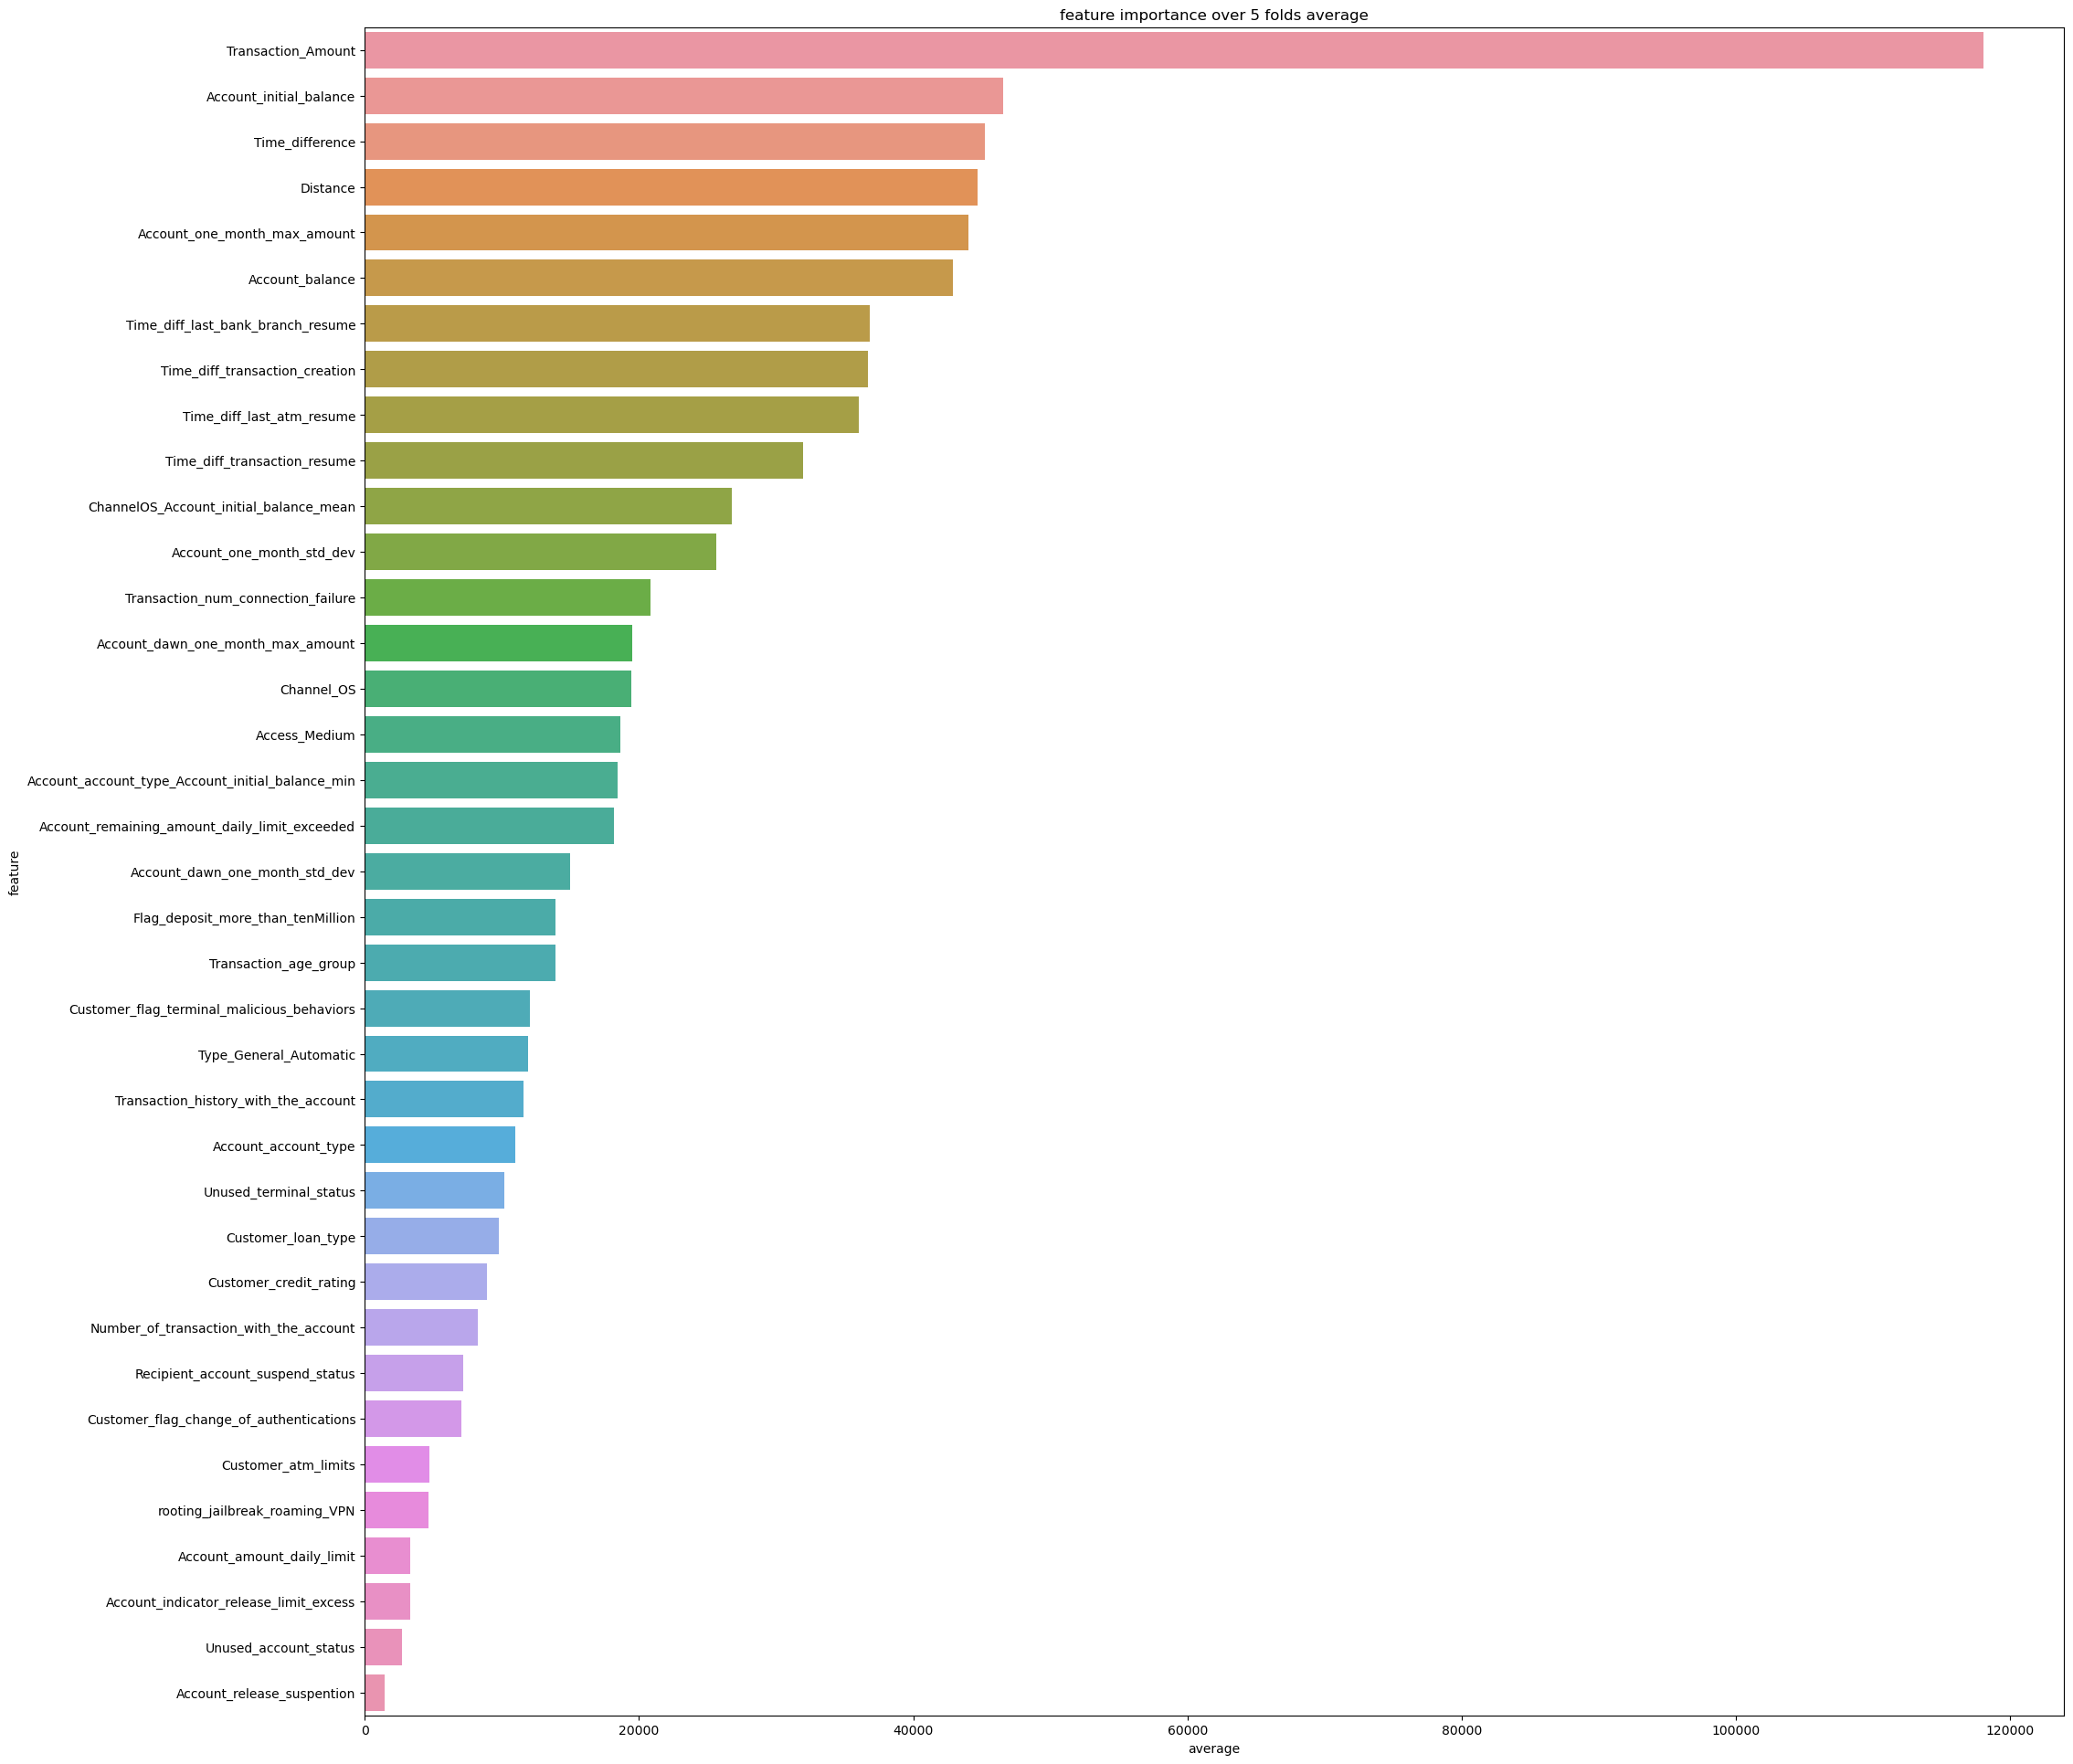

In [14]:
feature_importance = feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('log/feature_importances_lgb.csv')

plt.figure(figsize=(24, 24))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False), x='average', y='feature')
plt.title('feature importance over {} folds average'.format(folds.n_splits))
plt.savefig('log/feature_importances_lgb.png', dpi=300, bbox_inches='tight')

In [15]:
predictions_label = le.inverse_transform(np.argmax(preds, axis=1))
print(np.unique(predictions_label, return_counts=True))
logging.info(np.unique(predictions_label, return_counts=True))

submission = pd.read_csv("data/sample_submission.csv")
submission['Fraud_Type'] = predictions_label
submission.to_csv('submission/clf_submission_lgb.csv', index=False)

(array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm'],
      dtype=object), array([ 5029,  5365,  3691,  2558,  5388,  5616,  3234,  4727,  4842,
        4612,  4930,  4976, 65032]))


CatBoost

In [21]:
train_df = total_df[total_df['Fraud_Type'].notnull()]
test_df = total_df[total_df['Fraud_Type'].isnull()]

df_m = train_df[train_df["Fraud_Type"] == 'm'].sample(n=2400, random_state=42)
fraud_df = train_df[train_df["Fraud_Type"] != 'm']
train_df = pd.concat([df_m, fraud_df], ignore_index=True)

X = train_df[features].reset_index(drop=True)
y = train_df['Fraud_Type']

test_X = test_df[features].reset_index(drop=True)

# 라벨 인코딩
le = LabelEncoder()
y = le.fit_transform(y)
y = pd.Series(y)

def augment_data(X, y, fold):
    fold_syn_df = syn_df[syn_df["fold"] == fold]
    
    # Channel_OS별 Account_initial_balance의 평균 계산
    channel_os_mean = total_df.groupby('Channel_OS')['Account_initial_balance'].mean().reset_index()
    channel_os_mean.columns = ['Channel_OS', 'ChannelOS_Account_initial_balance_mean']
    fold_syn_df = fold_syn_df.merge(channel_os_mean, on='Channel_OS', how='left')

    # Account_account_type별 Account_initial_balance의 최소값 계산
    account_type_min = total_df.groupby('Account_account_type')['Account_initial_balance'].min().reset_index()
    account_type_min.columns = ['Account_account_type', 'Account_account_type_Account_initial_balance_min']
    fold_syn_df = fold_syn_df.merge(account_type_min, on='Account_account_type', how='left')
    
    syn_X = fold_syn_df[fold_syn_df["Fraud_Type"] != 'm'][features].reset_index(drop=True)
    syn_y = fold_syn_df[fold_syn_df["Fraud_Type"] != 'm']['Fraud_Type']
    
    syn_y = le.transform(syn_y)
    syn_y = pd.Series(syn_y)
        
    fold_X = pd.concat([X, syn_X], axis=0, sort=False)
    fold_X = fold_X.reset_index(drop=True)
    fold_y = pd.concat([y, syn_y], axis=0, sort=False)
    
    return fold_X, fold_y

def objective(trial, train_idx, test_idx):
    trial_params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'depth': trial.suggest_int('depth', 4, 7),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 127),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 10.0)
    }
    
    params.update(trial_params)
    
    clf = CatBoostClassifier(**params)
    clf.fit(X.iloc[train_idx], y.iloc[train_idx], eval_set=(X.iloc[test_idx], y.iloc[test_idx]), cat_features=categorical_columns, use_best_model=True)
    
    oofs[test_idx] = np.argmax(clf.predict_proba(X_val), axis=1)
    f1 = f1_score(y.iloc[test_idx], oofs[test_idx], average='macro')
    print(f"F1 Score (Macro): {f1 * 100:.2f}%")
    
    logging.info(f"Trial params: {trial_params}")
    logging.info(f"F1 Score (Macro): {f1 * 100:.2f}%")
    
    return f1

NFOLD = 5
folds = StratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=42)

#best_params = {'learning_rate': 0.007, 'depth': 4}
best_params = {'learning_rate': 0.007267480909096032, 'depth': 4, 'l2_leaf_reg': 0.024642191917171506, 'bagging_temperature': 0.2247973592889669, 'border_count': 58, 'random_strength': 0.031768335530550265}
#best_params = {'learning_rate': 0.0075171302329029525, 'depth': 4, 'l2_leaf_reg': 0.023163530400788595, 'bagging_temperature': 0.22063947280403945, 'border_count': 58, 'random_strength': 0.018984031619932385}
#best_params = {'learning_rate': 0.00719682918443487, 'depth': 4, 'l2_leaf_reg': 0.06906484870034817, 'bagging_temperature': 0.25410987261921997, 'border_count': 56, 'random_strength': 0.011531765820877136}

params = {
    'loss_function': 'MultiClass',
    'eval_metric': 'MultiClass',
    'iterations': 10000,
    'random_seed': 42,
    'verbose': 1000,
    'od_wait': 200,
    'task_type': 'GPU',
    'allow_writing_files': False
}

mcll = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
oofs = np.zeros(len(train_df))
preds = np.zeros((len(test_df), 13))

training_start_time = time()
for fold, (train_idx, test_idx) in enumerate(folds.split(X, y)):
    fold_start_time = time()
    print(f"\n========== Fold {fold + 1} Training Started ==========")
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[test_idx], y.iloc[test_idx]
    
    # 파라미터 튜닝
    #study = optuna.create_study(direction='maximize')
    #study.optimize(lambda trial: objective(trial, train_idx, test_idx), n_trials=3000)
    #best_params = study.best_params
    #print(best_params)
    params.update(best_params)
    
    # 데이터 증강
    #X_train, y_train = augment_data(X.iloc[train_idx], y.iloc[train_idx], fold)
    
    # 학습 시작
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=categorical_columns, use_best_model=True)
    
    oofs[test_idx] = np.argmax(clf.predict_proba(X_val), axis=1)
    preds += clf.predict_proba(test_X) / NFOLD
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.get_feature_importance()
    mcll.append(clf.get_best_score()["validation"]["MultiClass"])
    
    print(f'Fold {fold + 1} completed in {str(datetime.timedelta(seconds=time() - fold_start_time))}')
    print(f"Validation Multi-logloss: {clf.get_best_score()['validation']['MultiClass']:.4f}")
    print(f"Validation F1 Score (Macro): {f1_score(y.iloc[test_idx], oofs[test_idx], average='macro') * 100:.2f}%")
    
    report = classification_report(y.iloc[test_idx], oofs[test_idx], target_names=[str(label) for label in range(13)])
    logging.info(f"========== Fold {fold + 1}  ==========")
    logging.info(f"\n{report}")
    logging.info(f"Validation F1 Score (Macro): {f1_score(y.iloc[test_idx], oofs[test_idx], average='macro') * 100:.2f}%")
    
print("\n========== Training Complete ==========")
print(f'Total training time: {str(datetime.timedelta(seconds=time() - training_start_time))}')
print(f'Mean Validation Multi-logloss: {np.mean(mcll):.4f}')
print(f"Overall F1 Score (Macro): {f1_score(y, oofs, average='macro') * 100:.2f}%")
logging.info("\n========== Training Complete ==========")
logging.info(f"Overall F1 Score (Macro): {f1_score(y, oofs, average='macro') * 100:.2f}%")


========== Fold 1 Training Started ==========
0:	learn: 2.5138462	test: 2.5139101	best: 2.5139101 (0)	total: 23.6ms	remaining: 3m 56s
1000:	learn: 0.3862902	test: 0.5474315	best: 0.5474315 (1000)	total: 4.26s	remaining: 38.3s
2000:	learn: 0.2112537	test: 0.4461967	best: 0.4461724 (1999)	total: 8.48s	remaining: 33.9s
3000:	learn: 0.1285716	test: 0.4121849	best: 0.4121223 (2997)	total: 12.7s	remaining: 29.7s
4000:	learn: 0.0795497	test: 0.4010051	best: 0.4009962 (3998)	total: 17s	remaining: 25.5s
bestTest = 0.3982270983
bestIteration = 4538
Shrink model to first 4539 iterations.
Fold 1 completed in 0:00:20.884251
Validation Multi-logloss: 0.3982
Validation F1 Score (Macro): 68.58%

========== Fold 2 Training Started ==========
0:	learn: 2.5136834	test: 2.5144040	best: 2.5144040 (0)	total: 4.18ms	remaining: 41.8s
1000:	learn: 0.3932044	test: 0.5194998	best: 0.5194998 (1000)	total: 4.25s	remaining: 38.2s
2000:	learn: 0.2164007	test: 0.4027985	best: 0.4027985 (2000)	total: 8.41s	remaining:

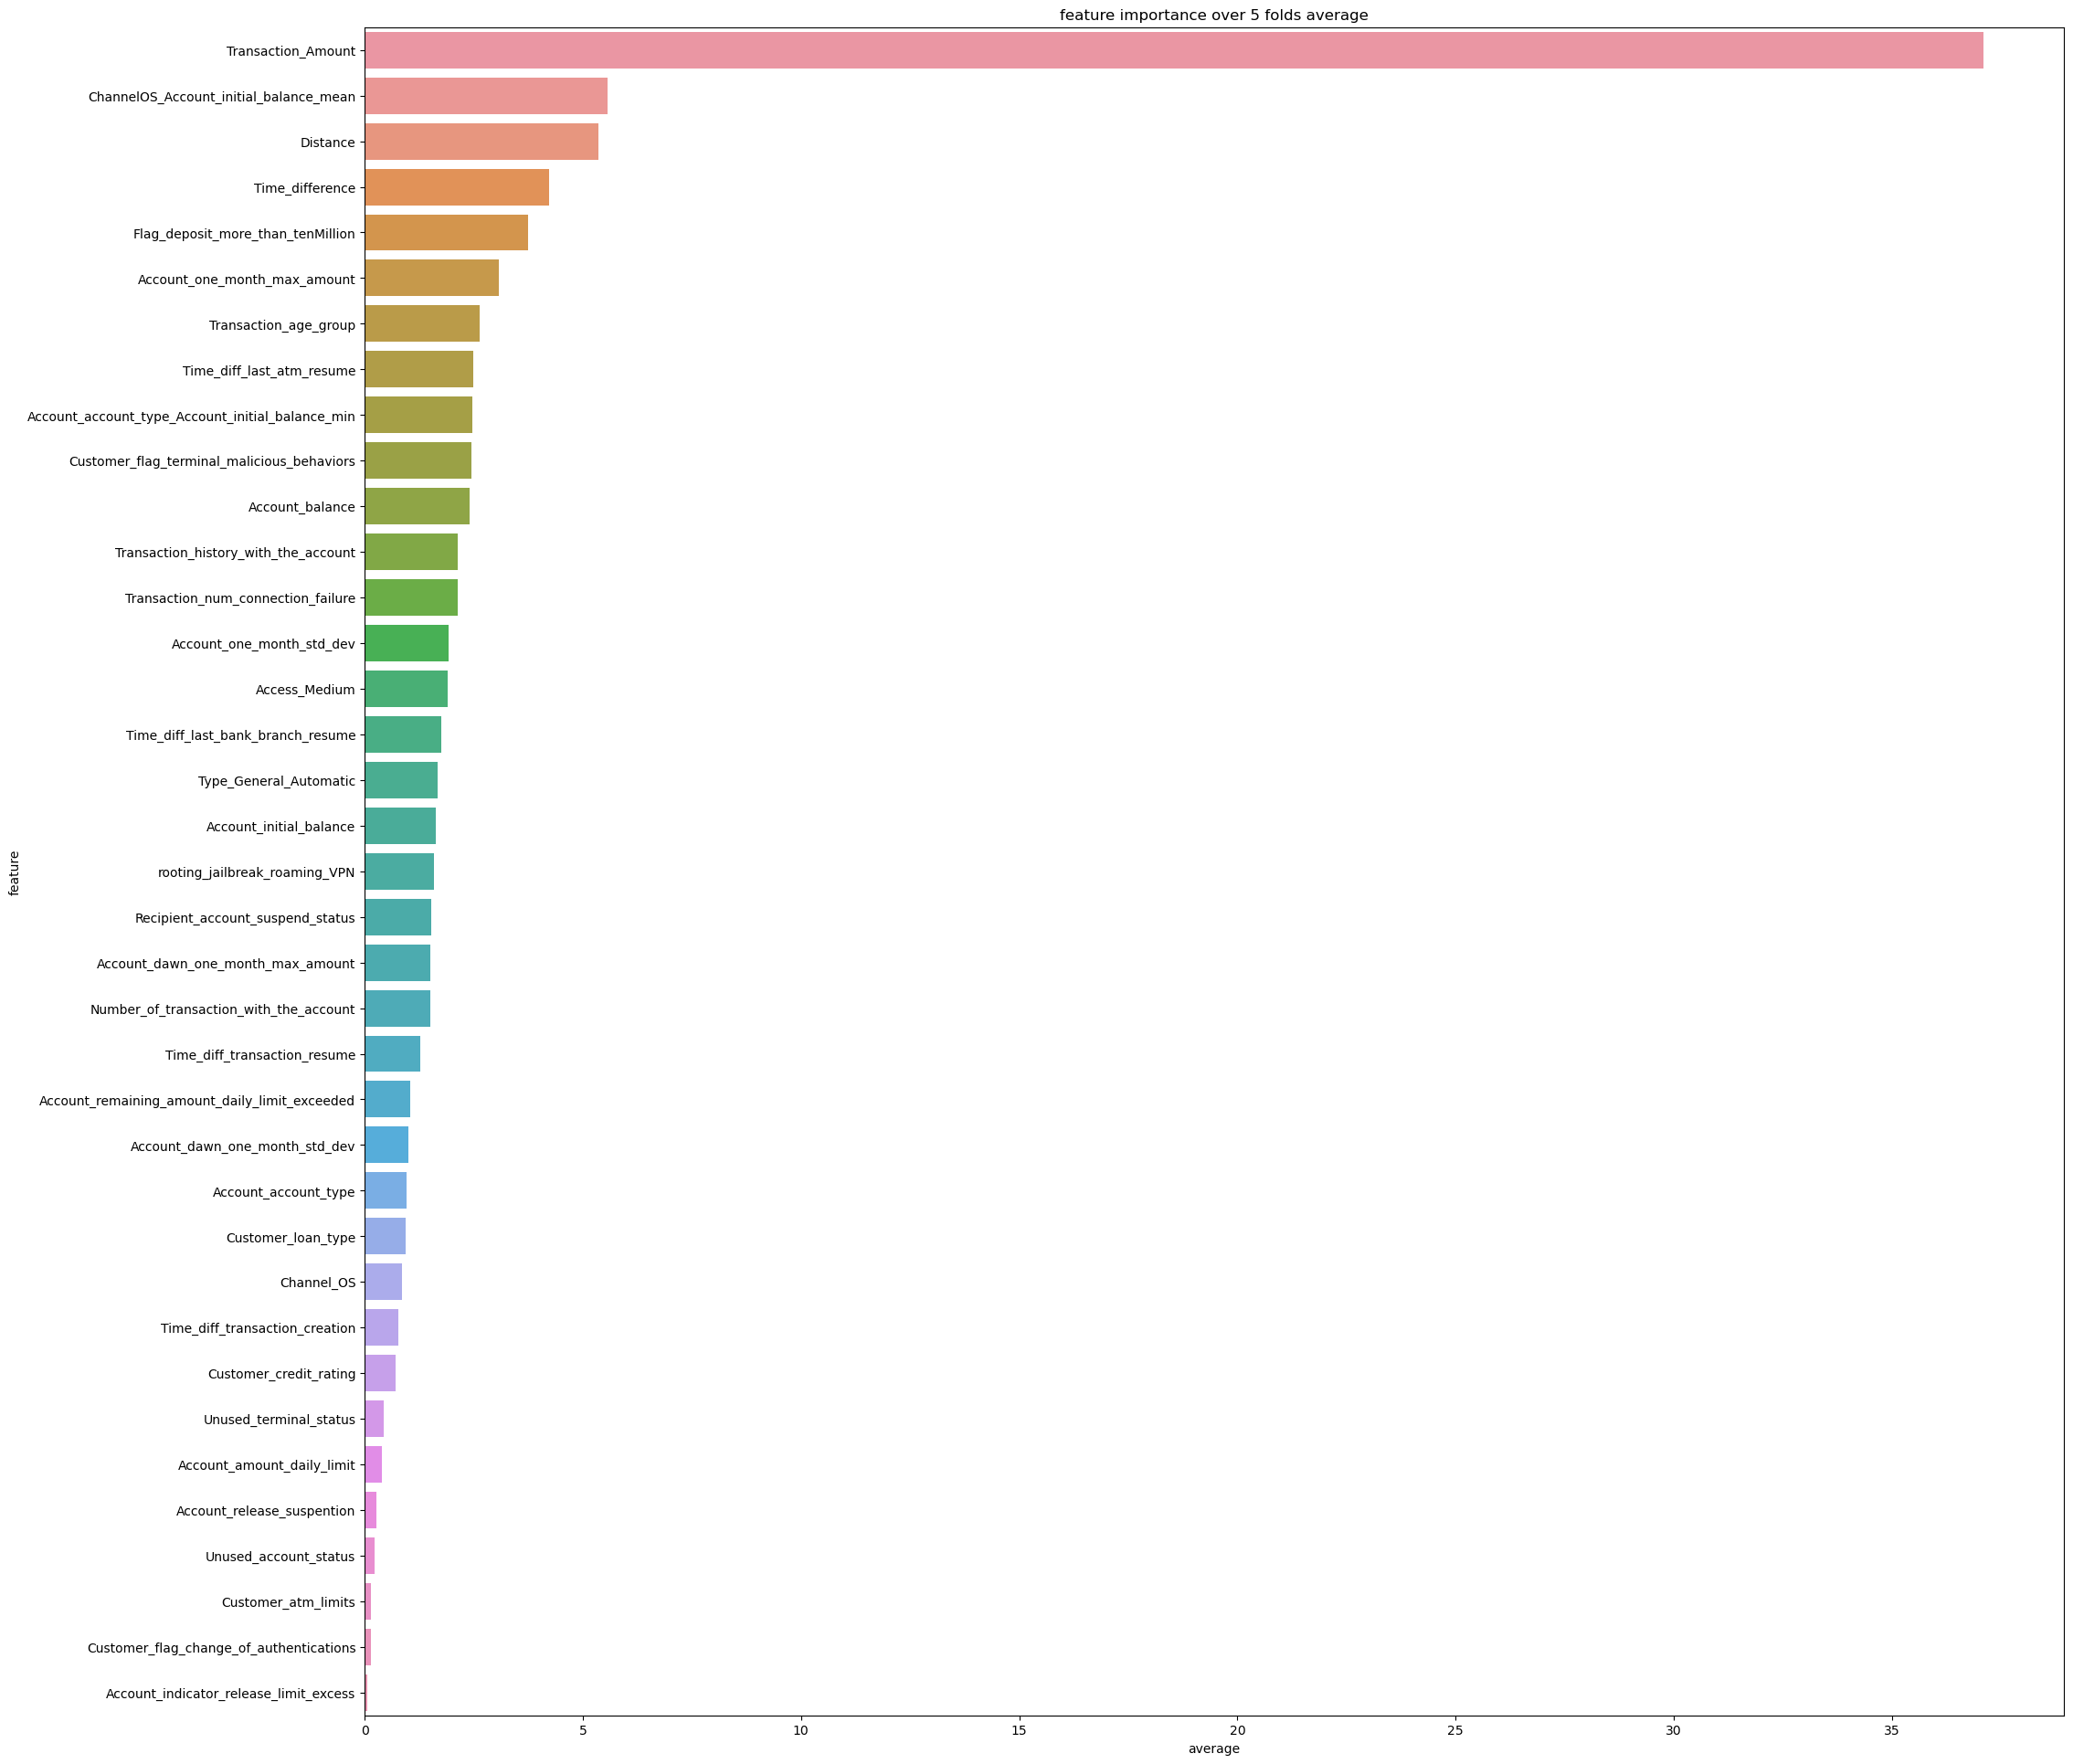

In [23]:
feature_importance = feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('log/feature_importances_cat.csv')

plt.figure(figsize=(24, 24))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False), x='average', y='feature')
plt.title('feature importance over {} folds average'.format(folds.n_splits))
plt.savefig('log/feature_importances_cat.png', dpi=300, bbox_inches='tight')